# Laboratorio 2: Preprocesamiento de datos

### Jhoan Sebastian Medina Jiménez

Exploramos el rendimiento de varios modelos de regresión lineal en un conjunto de datos del mundo real, es decir, [MoneyBall](https://www.openml.org/d/41021). Consulte la descripción en OpenML para obtener más información. En resumen, este conjunto de datos recoge datos de rendimiento de jugadores de béisbol. La tarea de regresión consiste en predecir con exactitud el número de "carreras" que puede anotar cada jugador, y comprender cuáles son los factores más importantes.



In [ ]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [ ]:
# Download MoneyBall data from OpenML
moneyball = oml.datasets.get_dataset(41021)
# Get the pandas dataframe (default)
X, y, _, attribute_names = moneyball.get_data(target=moneyball.default_target_attribute)

## Análisis exploratorio y visualización

En primer lugar, exploramos visualmente los datos visualizando la distribución de valores y la interacción entre todas las demás características en una matriz de dispersión. Utilizamos la característica objetivo como variable de color para ver qué características están correlacionadas con el objetivo.

Sin embargo, para que el gráfico funcione, tenemos que eliminar las características categóricas (las 2 primeras) y rellenar los valores que faltan. Averigüemos qué columnas tienen valores perdidos. Esto coincide con lo que ya vimos en la página OpenML (https://www.openml.org/d/41021).


In [ ]:
pd.isnull(X).any()

Team            False
League          False
Year            False
RA              False
W               False
OBP             False
SLG             False
BA              False
Playoffs        False
RankSeason       True
RankPlayoffs     True
G               False
OOBP             True
OSLG             True
dtype: bool

Para esta primera visualización rápida, simplemente imputaremos los valores perdidos utilizando la mediana. Eliminar todas las instancias con valores perdidos no es realmente una opción, ya que algunas características tienen valores perdidos consistentes: tendríamos que eliminar una gran cantidad de datos.

In [ ]:
# Impute missing values with sklearn and rebuild the dataframe
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_clean_array = imputer.fit_transform(X[attribute_names[2:]]) # skip the first 2 features
# The imputer will return a numpy array. To plot it we make it a pandas dataframe again.
X_clean = pd.DataFrame(X_clean_array, columns = attribute_names[2:]) #

A continuación, construimos la matriz de dispersión. Incluimos la columna del objetivo para ver qué características están fuertemente correlacionadas con el objetivo, y también utilizamos el valor del objetivo como color para ver qué combinaciones de características están correlacionadas con el objetivo.

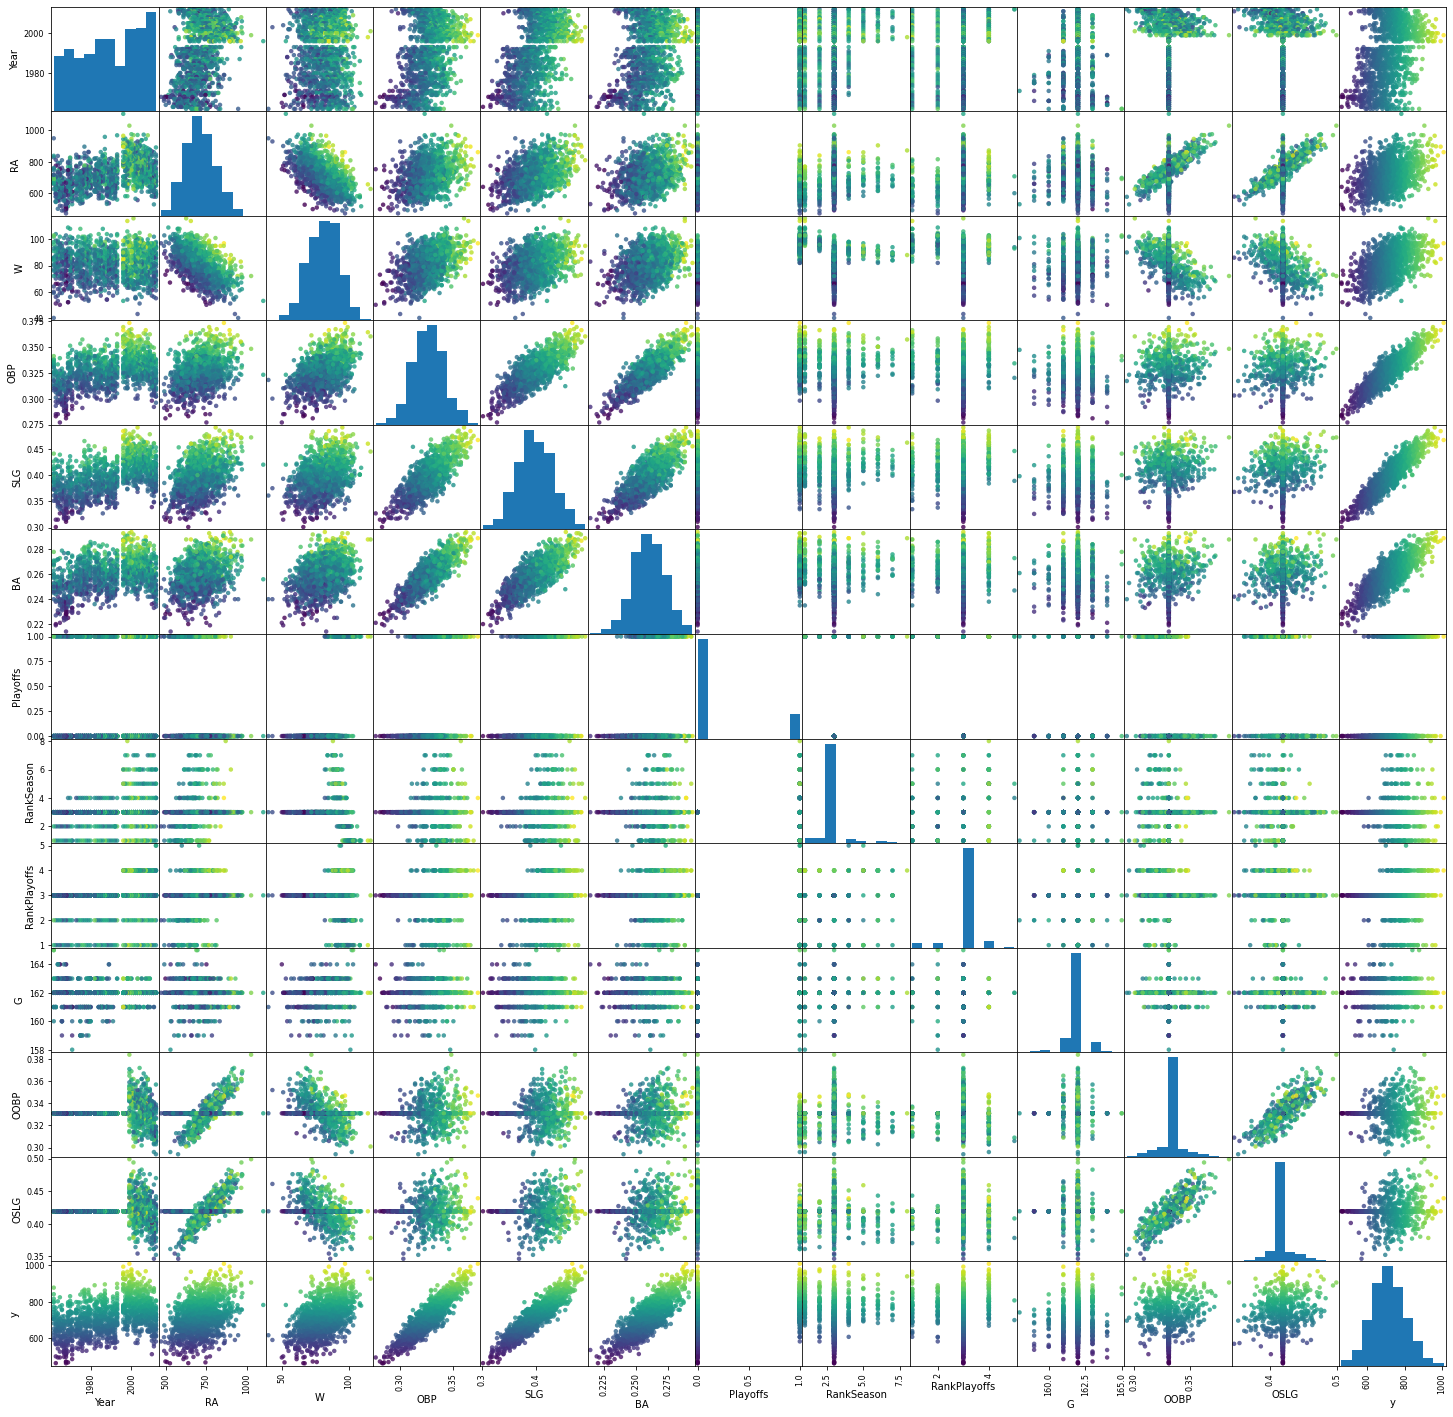

In [ ]:
from pandas.plotting import scatter_matrix

# Scatter matrix of dataframe including the target feature
copyframe = X_clean.copy() 
copyframe['y'] = pd.Series(y, index=copyframe.index)
scatter_matrix(copyframe, c=y, figsize=(25,25), 
               marker='o', s=20, alpha=.8, cmap='viridis');

Varias cosas destacan inmediatamente:
* OBP, SLG y BA se correlacionan fuertemente con el objetivo (casi-diagonales en la columna final), pero también las combinaciones de cualquiera de estos y W o R parecen útiles.
* RA, W, OBP, SLG y BA parecen distribuidos normalmente, la mayoría de los otros no. 
* OOBP y OSLG tienen una distribución con picos. 
* Playoffs' parece ser categórico y probablemente debería ser codificado como tal.

## Ejercicio 1: Construir un pipeline

Implementar una función `build_pipeline` que haga lo siguiente:
- Imputa los valores perdidos sustituyendo los NaN por la mediana de las características numéricas.
- Codificar las características categóricas utilizando OneHotEncoding.
- Si el atributo `scaling=True`, también escala los datos utilizando el escalado estándar.
- Adjuntar el modelo de regresión dado al final del pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


def build_pipeline(regressor, numerical, categorical, scaling=False):
    """ Build a robust pipeline with the given regression model
    Keyword arguments:
    regressor -- the regression model
    categorical -- the list of categorical features
    scaling -- whether or not to scale the data
    
    Returns: a pipeline
    """
    if scaling == True:
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
        )
        categorical_transformer = Pipeline(
            steps=[
                ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ]
        )
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numerical),
                ("cat", categorical_transformer, categorical),
            ]
        )
    else :
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="mean"))]
        )
        categorical_transformer = Pipeline(
            steps=[
                ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ]
        )
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numerical),
                ("cat", categorical_transformer, categorical),
            ]
        )
    reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", regressor)]
    )

    return reg

## Ejercicio 2: Probar el pipeline

Pruebe la tubería mediante la evaluación de regresión lineal (sin escalado) en el conjunto de datos, utilizando 5 veces validación cruzada y $R^2$. Asegúrese de ejecutarlo en el conjunto de datos original ('X'), no en la versión limpiada manualmente ('X_clean').

Para probar el pipeline se hace un ajuste de una regresión lineal donde se toman todas las variables y se hace escalado

In [ ]:
X.dtypes
numerical = ["Year","RA","W","OBP","SLG","BA","OOBP","OSLG"]
categorical = ["Team","League","Playoffs","RankSeason","RankPlayoffs"]


In [ ]:
from sklearn.linear_model import LinearRegression
test_pipe= build_pipeline(LinearRegression(), numerical, categorical, scaling=True)

In [ ]:
test_pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year', 'RA', 'W', 'OBP',
                                                   'SLG', 'BA', 'OOBP',
                                                   'OSLG']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Team', 'League', 'Playoffs',
                                              

In [ ]:
print("model score: %.3f" % test_pipe.score(X, y))

model score: 0.951


El pipeline funciona de manera correcta

Split training test

## Ejercicio 3: Un primer punto de referencia
Evalúe los siguientes algoritmos en su configuración por defecto, con y sin escalado, e interprete los resultados:  
- Regresión lineal
- Cresta
- Lasso
- SVM (RBF)
- Bosques aleatorios
- GradientBoosting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


models = {"LinearRegression":LinearRegression(),
            "Ridge":Ridge(),
            "Lasso":Lasso(),
            "SVR":SVR(),
            "RandomForestRegressor":RandomForestRegressor(),
            "GradientBoostingRegressor":GradientBoostingRegressor()}

modelo = []
r2_escalado =[] 
mse_escalado = []
r2 =[] 
mse = []
for i in models.keys():
    print(i)
    pipe =  build_pipeline(models[i], numerical, categorical, scaling=True)
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    mse_ = mean_squared_error (y_pred,y_test)
    r2_ =abs( r2_score (y_pred,y_test))
    modelo.append(i)
    r2_escalado.append(r2_)
    mse_escalado.append(mse_)
    # scaling False
    pipe =  build_pipeline(models[i], numerical, categorical, scaling=False)
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    mse_ = mean_squared_error (y_pred,y_test)
    r2_ =abs( r2_score (y_pred,y_test))
    r2.append(r2_)
    mse.append(mse_)


LinearRegression
Ridge
Lasso
SVR
RandomForestRegressor
GradientBoostingRegressor


In [ ]:
results = pd.DataFrame(
    {'modelo': modelo,
     'mse': mse,
     'r2': r2,
     'mse escalado': mse_escalado,
     'r2 escalado': r2_escalado
    })
results

,modelo,mse,r2,mse escalado,r2 escalado
0,LinearRegression,427.140914,0.944699,427.583723,0.944650
1,Ridge,1048.796727,0.851959,427.852020,0.944552
2,Lasso,1042.631288,0.852187,426.822152,0.942683
3,SVR,7898.795198,8211.855682,2839.721557,0.453830
4,RandomForestRegressor,594.224174,0.921448,597.826417,0.920436
5,GradientBoostingRegressor,486.841554,0.936201,490.823429,0.935799


Se puede observar de los resultados que los modelos tienen un mejor performance cuando se hace el escalado de los datos, de hecho todos se comportan de manera similar a excepción  del SVR dado que puede faltar una optimización de los parámetros. Se puede concluír que el escalado es necesario para mejorar el r2 de los modelos y que todos los modelos tienen un r2 muy similar (menos SVR) y que se puede entrar a evaluar otras métricas como mse, entre otras métricas de bondad de ajuste para determinar cuál es el mejor para el problema en cuestión

## Ejercicio 4: Ajuste de modelos lineales
A continuación, visualice el efecto del regularizador alfa para Ridge y Lasso. Varíe alfa de 1e-4 a 1e6 y trace la puntuación $R^2$ como un gráfico de líneas (una línea para cada algoritmo). Utilice datos escalados aquí. Interpretar los resultados.

Se pone a iterar el alpha,, si es de 0.0001 a 1 cada 0.01 y de 1 a 1000.000 cada 50

In [ ]:
alpha =  np.concatenate(( np.arange(1e-4,1,0.01), np.arange(1,1000001,50)), axis=None)
len(alpha)

20100

In [ ]:
alpha_sim = []
r2_ridge = []
mse_ridge = []
r2_lasso = []
mse_lasso = []

for a in alpha:
    print(a)
    # Ridge
    pipe_ridge =  build_pipeline(Lasso(alpha=a), numerical, categorical, scaling=True)
    pipe_ridge.fit(X_train,y_train)
    y_pred = pipe_ridge.predict(X_test)
    mse_ = mean_squared_error (y_pred,y_test)
    r2_ =abs( r2_score (y_pred,y_test))
    r2_ridge.append(r2_)
    mse_ridge.append(mse_)
    # Lasso
    pipe_lasso =  build_pipeline(models[i], numerical, categorical, scaling=True)
    pipe_lasso.fit(X_train,y_train)
    y_pred = pipe_lasso.predict(X_test)
    mse = mean_squared_error (y_pred,y_test)
    r2 =abs( r2_score (y_pred,y_test))
    r2_lasso.append(r2)
    mse_lasso.append(mse)

    alpha_sim.append(a)



0.0001


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5482.535552830901, tolerance: 740.0383323665894
  model = cd_fast.sparse_enet_coordinate_descent(


0.0101
0.0201
0.0301
0.040100000000000004
0.050100000000000006
0.0601
0.07010000000000001
0.0801
0.0901
0.10010000000000001
0.1101
0.1201
0.1301
0.1401
0.15009999999999998
0.1601
0.1701
0.18009999999999998
0.1901
0.2001
0.21009999999999998
0.2201
0.2301
0.24009999999999998
0.2501
0.2601
0.2701
0.2801
0.29009999999999997
0.3001
0.3101
0.3201
0.3301
0.3401
0.3501
0.3601
0.3701
0.3801
0.3901
0.4001
0.4101
0.4201
0.4301
0.4401
0.4501
0.4601
0.4701
0.48009999999999997
0.4901
0.5001
0.5101
0.5201
0.5301
0.5401
0.5501
0.5601
0.5701
0.5801
0.5901
0.6001
0.6101
0.6201
0.6301
0.6401
0.6501
0.6601
0.6701
0.6801
0.6901
0.7001000000000001
0.7101
0.7201
0.7301
0.7401
0.7501
0.7601
0.7701
0.7801
0.7901
0.8001
0.8101
0.8201
0.8301000000000001
0.8401
0.8501
0.8601
0.8701
0.8801
0.8901
0.9001
0.9101
0.9201
0.9301
0.9401
0.9501000000000001
0.9601
0.9701
0.9801
0.9901
1.0
51.0
101.0
151.0
201.0
251.0
301.0
351.0
401.0
451.0
501.0
551.0
601.0
651.0
701.0
751.0
801.0
851.0
901.0
951.0
1001.0
1051.0
1101.0
1

In [ ]:
df_describe = pd.DataFrame(r2_lasso)
df_describe.describe()


,0
count,20100.000000
mean,0.935811
std,0.000131
min,0.935319
25%,0.935722
50%,0.935809
75%,0.935899
max,0.936296


Al graficar el R2 dentro del recorrido del alpha se puede notar que no hay una tendencia particular  es decir que no hay un máximo absoluto del r2 para un alpha o rango de alphas. Adicionalmente se puede  ver que sacando los estadísticos descriptivos para los alpha no hay un valor óptico pues la desviación estándar de los alphas es muy baja (0.001%)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

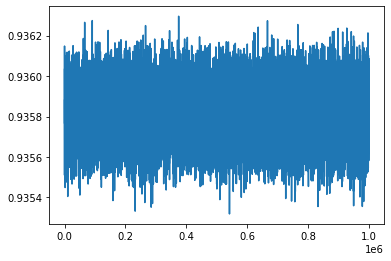

In [ ]:
sns.lineplot(alpha_sim,r2_lasso)

Al graficar  los alphas Ridge se puede ver que para los valores mayores a 1 de alpha el  r2  tiene un desajuste y es 6. Por tanto se puede concluír que para alphas mayores a 6 no converge el algoritmo

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

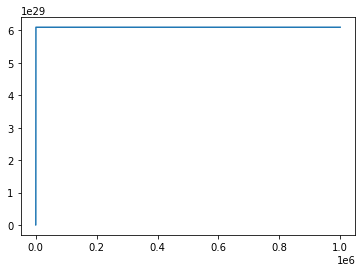

In [ ]:
sns.lineplot(alpha_sim,r2_ridge)

Para los alphas ente 0.0001 y 1 se tiene que no hay una variación significativaa pero si hay un valor óptimo entre 0.15 y 0.2 donde el r2 se maximiza

In [ ]:
df_describe = pd.DataFrame(r2_ridge[:100])
df_describe.describe()

,0
count,100.000000
mean,0.944482
std,0.000913
min,0.942728
25%,0.943760
50%,0.944586
75%,0.945175
max,0.945886


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

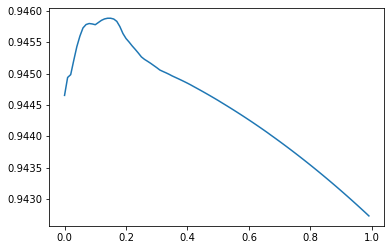

In [ ]:
sns.lineplot(alpha_sim[:100],r2_ridge[:100])


## Ejercicio 5: Afinar SVMs
A continuación, sintonice el C y gamma de SVM. Puede permanecer dentro del rango de 1e-6 a 1e6. Trace la puntuación $R^2$ como un mapa de calor  usando datos sin escalar. Cree una función para resolver el punto.

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [ ]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [ ]:
def tune_svm_hyperparameters(scaling, X_train, y_train, C_range=(-6, 6), gamma_range=(-6, 6), n_splits=5, scoring='r2', cmap='viridis'):
    # Create a pipeline with the SVM regressor
    pipeline = build_pipeline(SVR(), numerical, categorical, scaling=scaling)

    # Define the search space for the hyperparameters
    C_values = np.logspace(C_range[0], C_range[1], 13)
    gamma_values = np.logspace(gamma_range[0], gamma_range[1], 13)
    param_grid = {'classifier__C': C_values, 'classifier__gamma': gamma_values}

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=n_splits, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Plot the R2 scores as a heatmap
    mean_scores = np.array(grid_search.cv_results_['mean_test_score']).reshape(len(C_values), len(gamma_values))
    xlabel = 'Gamma'
    ylabel = 'C'
    xticklabels = gamma_values
    yticklabels = C_values
    fig, ax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    im = heatmap(mean_scores, xlabel, ylabel, xticklabels, yticklabels, cmap=cmap, ax=ax)
    plt.show()

    # Return the best hyperparameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    return best_params, best_score


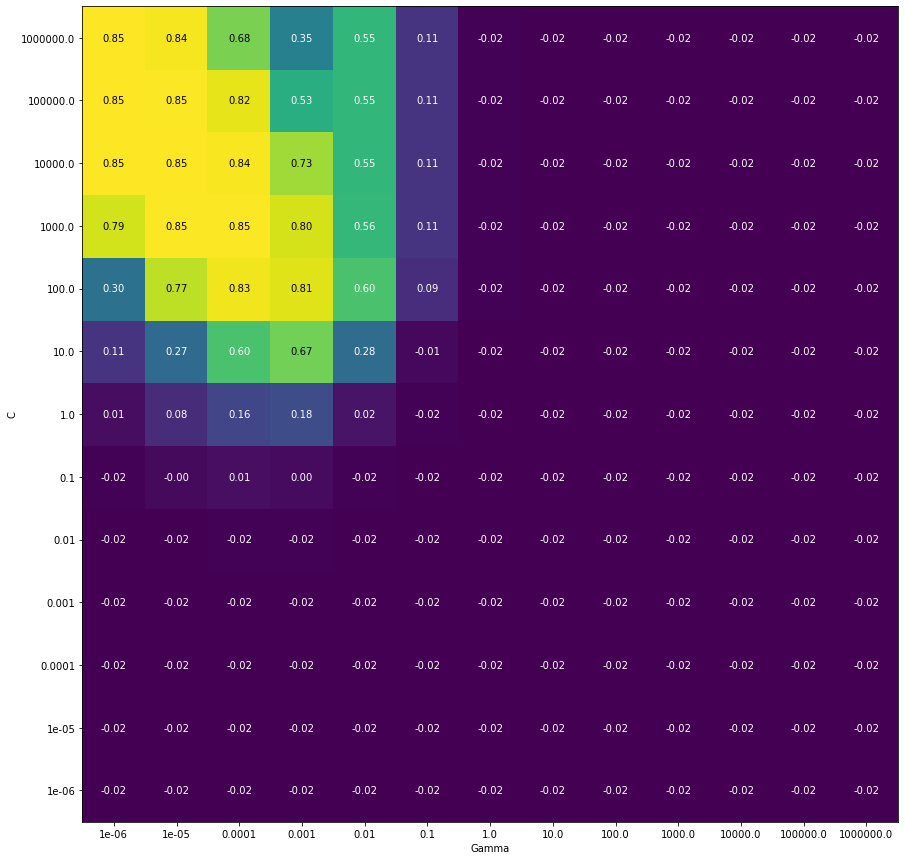

({'classifier__C': 100000.0, 'classifier__gamma': 1e-06}, 0.8525278928928497)

In [ ]:
tune_svm_hyperparameters(False, X_train, y_train, C_range=(-6, 6), gamma_range=(-6, 6), n_splits=5, scoring='r2', cmap='viridis')

## Ejercicio 5b: Ajuste de SVMs (2)
Vuelva a dibujar el mapa de calor, pero ahora utilice el escalado. ¿Qué observa?

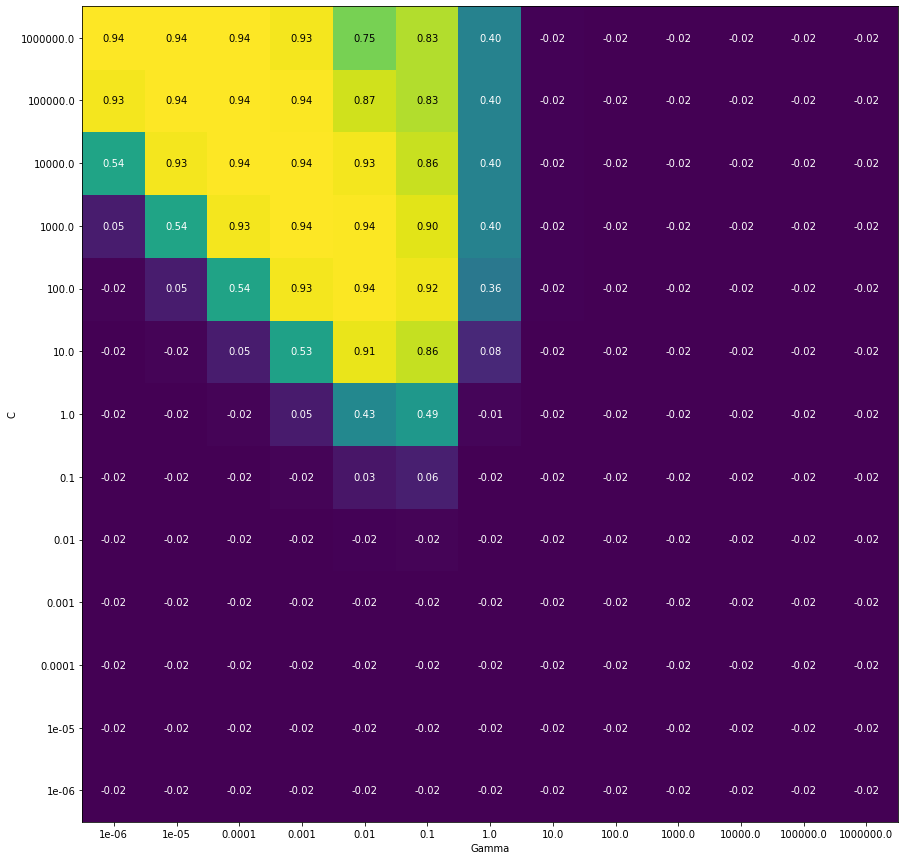

({'classifier__C': 1000.0, 'classifier__gamma': 0.001}, 0.9436308605933796)

In [ ]:
tune_svm_hyperparameters(True, X_train, y_train, C_range=(-6, 6), gamma_range=(-6, 6), n_splits=5, scoring='r2', cmap='viridis')

En la matriz no escalada se puede visualizar que los R2 son mas bajos que los de la matriz escalada, por ejemplo los mejores parametros de la primera matriz da un R2:0.85, en cambio, el mejor parametro de la escalada da un R2: 0.94. 

La matriz escalada nos muestra que existen 24 combinaciones de hiperparametros entre C y gamma que dan un mejor resultado que el mas alto de la matriz sin escalar. Por lo tanto, se ven los beneficios en performance de usar el escalado vs no usarlo.

## Ejercicio 6: Importancia de las características 
Recupere los coeficientes de los modelos optimizados Lasso, Ridge, y las importancias de las características de los modelos por defecto RandomForest y GradientBoosting.
Compare los resultados.
¿Concuerdan los distintos modelos en qué características son importantes? Tendrá que asignar los nombres codificados de las características a los coeficientes correctos y a las importancias de las características.

Si puede, represente las importancias en un gráfico de barras.

### Coeficientes ridge y lasso
Dados los resultados del punto 4, se usa para ridge un alpha de 1.85 y para lasso dado que no hay un optimo claro se usa el parámetro alpha por defecto

In [ ]:
# Ridge coeficientes
ridge = Ridge(alpha=1.85)
pipeline_r = build_pipeline(ridge,numerical,categorical,scaling=True)
pipeline_r.steps[-1] = ('regressor', ridge)
pipeline_r.fit(X_train, y_train)
coefficients_r = pipeline_r.named_steps['regressor'].coef_
features_r = pipeline_r.named_steps['preprocessor'].get_feature_names_out()

# Lasso coeficientes
lasso = Lasso()
pipeline_l = build_pipeline(lasso,numerical,categorical,scaling=True)
pipeline_l.steps[-1] = ('regressor', lasso)
pipeline_l.fit(X_train, y_train)
coefficients_l = pipeline_l.named_steps['regressor'].coef_
features_l = pipeline_l.named_steps['preprocessor'].get_feature_names_out()

print(coefficients_r)
print(features_r)


[ -4.728948    23.138185    27.25810046  32.13181172  41.45131709
  -1.71518509  -0.17648139   1.17685621  -2.28135059  -2.36946115
   5.90489214 -12.52558527  -8.74278152  -4.9649129    7.3081615
   1.34078803   1.2627139   -4.43590775   9.42955818  -7.30371059
  -8.41243658   8.21195304  -4.81256232   1.03196141  -3.79969882
   6.39794629   4.26986958  -5.51649833   4.9179769   -0.16883304
  11.30016032  -1.74796184   2.31067744   2.20197444   5.74457203
   3.03943495  -7.20607178   3.46825689  13.20010888 -11.02779626
   3.70491687   1.81607162  -1.99400918  -1.7850972   -7.76731927
   6.31132002  -6.31132002  -0.60960701   0.60960701   4.35993689
   1.3919971    6.24710008   4.05765164  -6.20380449 -11.42117019
  -3.67862137   5.85651736  -0.60960701   1.9791742   -3.96735058
  -3.37389935   5.97168274  -0.60960701]
['num__Year' 'num__RA' 'num__W' 'num__OBP' 'num__SLG' 'num__BA'
 'num__OOBP' 'num__OSLG' 'cat__Team_ANA' 'cat__Team_ARI' 'cat__Team_ATL'
 'cat__Team_BAL' 'cat__Team_BOS

### Coeficientes ridge

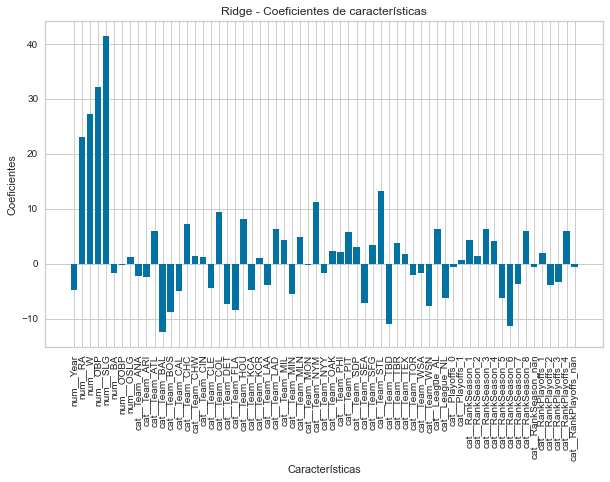

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(range(len(coefficients_r)), coefficients_r)
plt.xticks(range(len(features_r)), features_r, rotation=90)
plt.xlabel('Características')
plt.ylabel('Coeficientes')
plt.title('Ridge - Coeficientes de características')
plt.show()

### Coeficientes Lasso

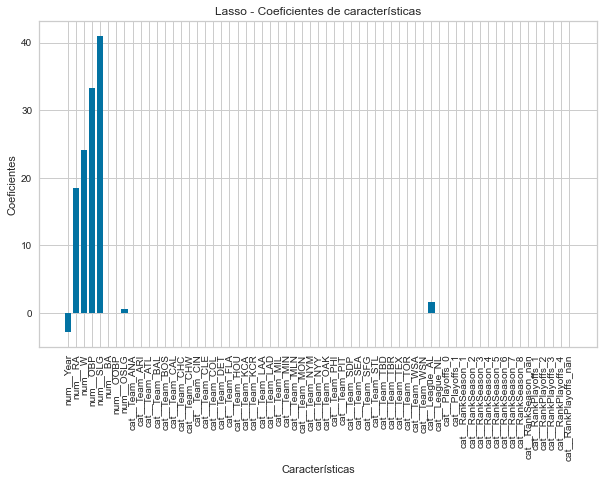

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(range(len(coefficients_l)), coefficients_l)
plt.xticks(range(len(features_l)), features_l, rotation=90)
plt.xlabel('Características')
plt.ylabel('Coeficientes')
plt.title('Lasso - Coeficientes de características')
plt.show()

### Importancia características

In [ ]:
# RandomForest importancias de características
rf = RandomForestRegressor()
pipeline_rf = build_pipeline(rf,numerical,categorical,scaling=False)
pipeline_rf.steps[-1] = ('regressor', rf)
pipeline_rf.fit(X_train, y_train)
importances_rf = pipeline_rf.named_steps['regressor'].feature_importances_
features_rf = pipeline_rf.named_steps['preprocessor'].get_feature_names_out()

gb = GradientBoostingRegressor()
pipeline_gb = build_pipeline(gb,numerical,categorical,scaling=False)
pipeline_gb.steps[-1] = ('regressor', gb)
pipeline_gb.fit(X_train, y_train)
importances_gb = pipeline_gb.named_steps['regressor'].feature_importances_
features_gb = pipeline_gb.named_steps['preprocessor'].get_feature_names_out()

print(importances_rf)
print(importances_gb)


[7.75581449e-03 8.59831902e-03 1.32742071e-02 2.54998014e-01
 6.86874403e-01 9.22856911e-03 1.85644715e-03 1.82482540e-03
 1.76099943e-04 1.55067848e-04 3.32762637e-04 3.64843655e-04
 2.81793708e-04 1.50907909e-04 4.79284530e-04 5.92677082e-04
 3.72195147e-04 3.54045594e-04 4.59709052e-05 4.25327149e-04
 1.26709819e-04 4.44287240e-04 4.20867932e-05 3.00683826e-04
 8.20491490e-05 3.01665915e-04 6.55168110e-04 2.19591210e-04
 8.07774113e-06 1.27710655e-04 2.56025380e-04 3.09631078e-04
 8.69420078e-04 4.49164140e-04 2.32515793e-04 3.14244802e-04
 5.57374827e-04 4.93505702e-04 5.50402604e-04 7.74633138e-05
 2.75362030e-05 6.31212561e-04 5.20238048e-04 1.45002586e-04
 5.98464491e-05 8.07543778e-04 8.64188842e-04 1.83682992e-04
 1.57037368e-04 1.81003514e-04 3.94815142e-04 9.63227139e-05
 6.84124943e-05 2.15055879e-05 1.39898274e-04 3.11829673e-06
 1.07275604e-05 1.84960525e-04 1.72116820e-04 2.59246109e-04
 1.89630663e-04 1.60464384e-04 1.62134771e-04]
[3.49708045e-03 9.71967454e-03 1.70811

### Importancia Random Forest

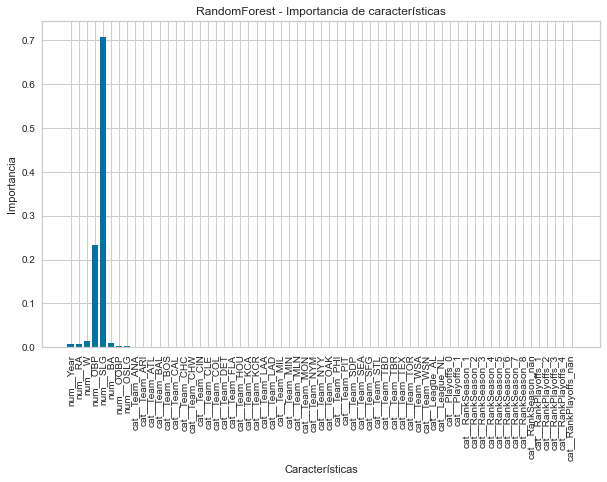

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(range(len(importances_rf)), importances_rf)
plt.xticks(range(len(features_rf)), features_rf, rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('RandomForest - Importancia de características')
plt.show()

### Importancia Grandient Boosting

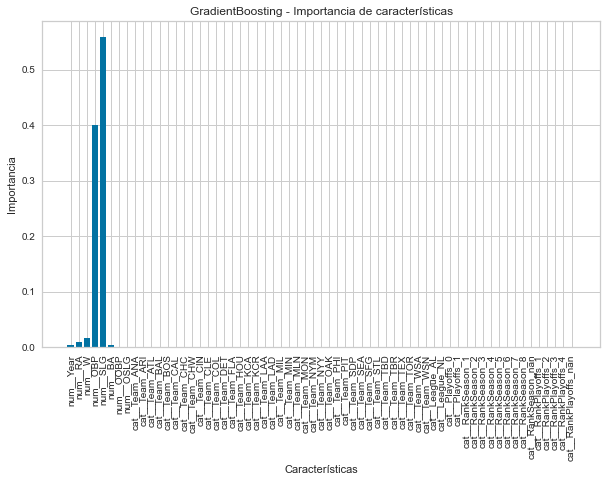

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(range(len(importances_gb)), importances_gb)
plt.xticks(range(len(features_gb)), features_gb, rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('GradientBoosting - Importancia de características')
plt.show()

### Respuesta:
En los cuatro modelos se puede evidenciar que la variable más importante es la que se llama 'num_SLG', tiene más peso en los modelos Random Forest y Grand Boosting, y, posee los coefcientes más altos en Lasso y Ridge

Además se puede ver que, las variables más importantes o que pesan más, son casi las mismas para Random Forest y Gradient Boosting, solo se diferencian en el peso o la importancia de cada variable. Estas varibles son: num_OBP y num_SLG.

Se puede concluir qeu la importancia de las variables es muy similar entre los diferentes modelos y que hay algunas variables como OSLG que pueden entrar en algunos modelos y en otros no
